In [38]:
from DistantSpeech.beamformer.utils import load_audio
from scipy.signal import convolve as conv
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
from DistantSpeech.adaptivefilter.BaseFilter import BaseFilter, awgn
from DistantSpeech.adaptivefilter import FastFreqLms, SubbandLMS, SubbandRLS
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.transform.transform import Transform
from DistantSpeech.transform.subband import Subband
from DistantSpeech.beamformer.utils import pt

(336567,)


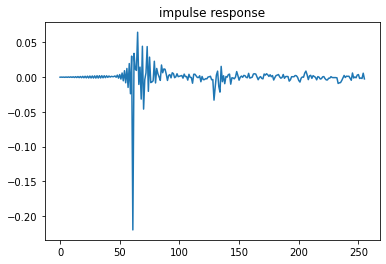

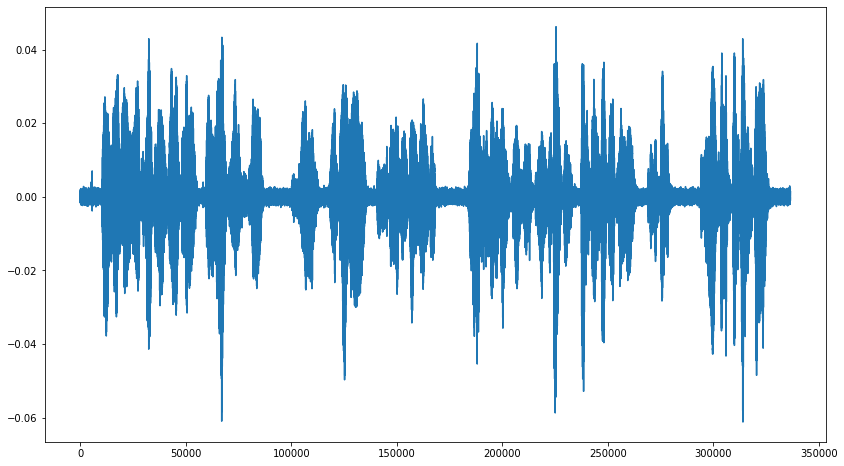

In [39]:
# load source single and rir
src = load_audio('/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3.wav')
# src = np.random.rand(len(src))-0.5# * np.sqrt(npower)
print(src.shape)
rir = load_audio('/home/wangwei/work/DistantSpeech/DistantSpeech/adaptivefilter/rir.wav')
rir = rir[200:]

filter_len = 256

rir = rir[:filter_len, np.newaxis]
plt.figure()
plt.plot(rir)
plt.title('impulse response')
plt.show()

# src = awgn(src, 30)

SNR = 20
data_clean = conv(src, rir[:, 0])
data = data_clean[:len(src)]
data = awgn(data, SNR)
pt(data)

(336567,)
(336567,)
Loading analysis prototype from '/home/wangwei/work/DistantSpeech/DistantSpeech/transform/prototype.ny/h-M512-m2-r1.pickle'
Loading synthesis prototype from '/home/wangwei/work/DistantSpeech/DistantSpeech/transform/prototype.ny/g-M512-m2-r1.pickle'
self.h:(1024,)
self.g:(1024,)
Loading analysis prototype from '/home/wangwei/work/DistantSpeech/DistantSpeech/transform/prototype.ny/h-M512-m2-r1.pickle'
Loading synthesis prototype from '/home/wangwei/work/DistantSpeech/DistantSpeech/transform/prototype.ny/g-M512-m2-r1.pickle'
self.h:(1024,)
self.g:(1024,)


100%|██████████| 336311/336311 [00:11<00:00, 30166.05it/s]


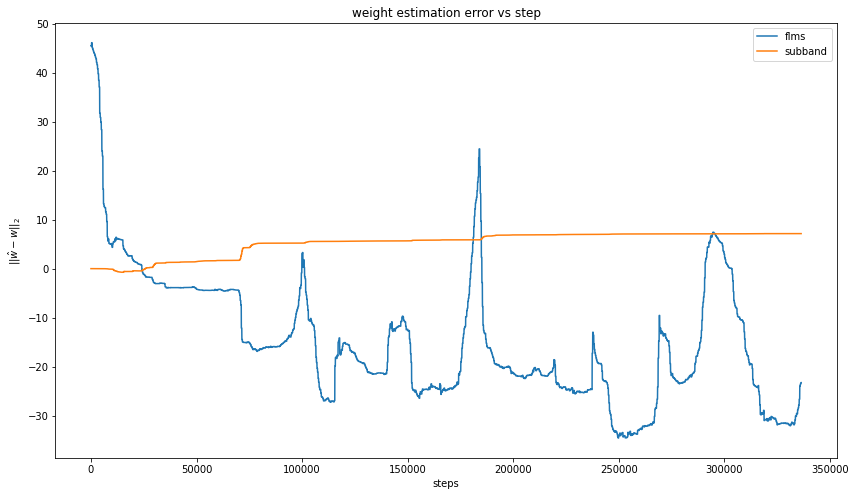

In [40]:




print(src.shape)
print(data.shape)
# audiowrite('src.wav', src)
# audiowrite('data.wav', data)

# array_data = audioread("/home/wangwei/work/DistantSpeech/example/mix.wav")
# src = array_data[:, 0]
# data = array_data[:, 1]

w = np.zeros((filter_len, 1))

transform_x = Transform(n_fft=512, hop_length=256)
transform_d = Transform(n_fft=512, hop_length=256)

subband_rls = SubbandRLS(filter_len=2, num_bands=512) # use nyq subband

flms = FastFreqLms(filter_len=filter_len, mu=0.1)

valid_len = len(src)-flms.filter_len  # discard last frame

est_err_flms = np.zeros(valid_len)
est_err_stftlms = np.zeros(valid_len)
est_err_subbandrls = np.zeros(valid_len)

output_flms = np.zeros(data.shape)
output_stftlms = np.zeros(data.shape)
output_subbandrls = np.zeros(data.shape)

for n in tqdm(range((valid_len))):
    if np.mod(n, flms.filter_len) == 0:
        input_vector = src[n: n +  flms.filter_len]
        d_vector = data[n : n + flms.filter_len]

        err, w_flms = flms.update(input_vector, d_vector)
        output_flms[n : n + flms.filter_len] = err[:, 0]

        subband_err_td, W_subbandlms = subband_rls.update(input_vector, d_vector)
        output_subbandrls[n : n + flms.filter_len] = subband_err_td

        # stft_err_fd, W_stftlms = subband_rls.update(transform_x.analysis(input_vector), transform_d.analysis(d_vector))
        # output_subbandrls[n : n + flms.filter_len] = transform_d.synthesis(stft_err_fd)

        # print(W_subbandlms.shape)
        w_rls = np.fft.irfft(W_subbandlms[:, 0])
        # w_rls2 = np.fft.irfft(W_subbandlms[:, 1])

    est_err_flms[n] = np.sum(np.abs(rir - w_flms[:len(rir)])**2)
    est_err_subbandrls[n] = np.sum(np.abs(np.abs(rir[1:, 0] - w_rls[:len(rir[:, 0])-1]))**2)
    

plt.figure(figsize=(14,8))
plt.plot(10 * np.log(est_err_flms / np.sum(np.abs(rir[:, 0])**2)) + 1e-6)
plt.plot(10 * np.log(est_err_subbandrls / np.sum(np.abs(rir[:, 0])**2)) + 1e-6)
plt.legend(['flms', 'subband'], loc='upper right')
plt.xlabel("steps")
plt.ylabel("$\||\hat{w}-w\||_2$")
plt.title('weight estimation error vs step')
plt.show()

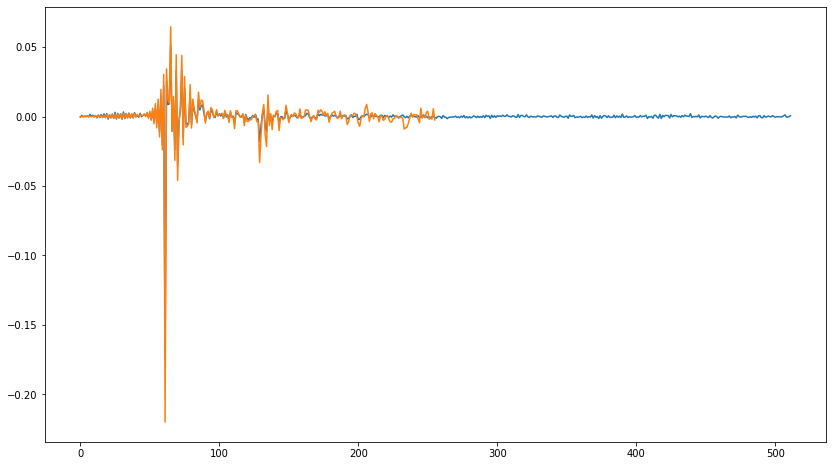

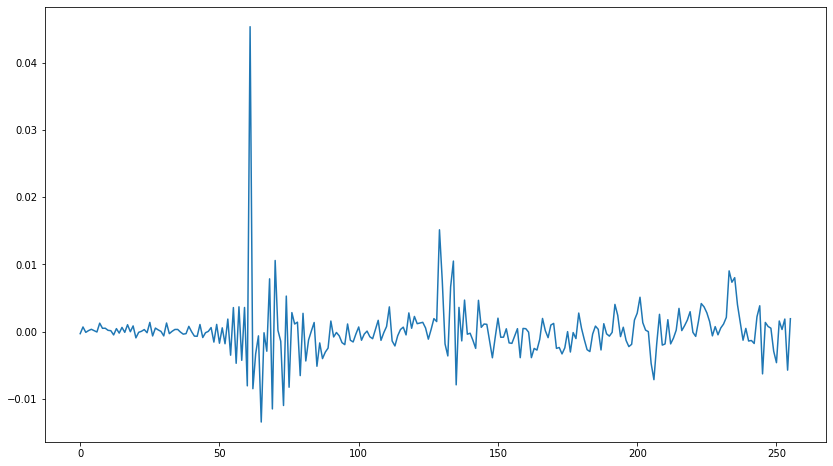

In [41]:
plt.figure(figsize=(14,8))
plt.plot(w_rls)
plt.plot(rir[:, 0])
plt.show()
plt.figure(figsize=(14,8))
# plt.plot(w_rls)
plt.plot(w_rls[:256]-rir[:, 0])
plt.show()
# pt(w_rls2)

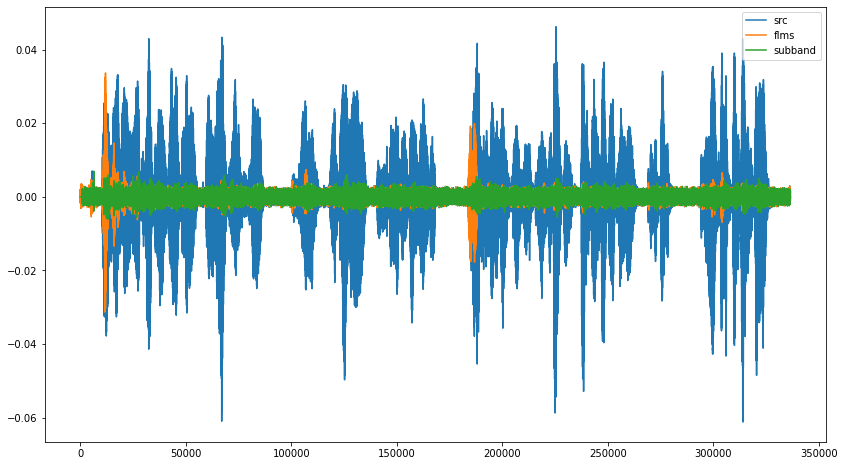

In [42]:
plt.figure(figsize=(14,8))
plt.plot(data)
plt.plot(output_flms)
plt.plot(output_subbandrls)

# plt.ylim([-0.05,0.05])
plt.legend(['src','flms', 'subband'], loc='upper right')
plt.show()
audiowrite('flms.wav', output_flms)
audiowrite('subbandrls.wav', output_subbandrls)